In [1]:
###### load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import binarize
import pickle
import seaborn as sns
# from matplotlib.colors import LogNorm, Normalize
from mapseq_fxns import sort_by_celltype
# from math import log10
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests

%matplotlib inline



In [2]:
# variables
M220_in = '/Volumes/Data/Emily/MAPseq/2301_MAPseq/python_analysis_M220/data_objects/'
M194_in = '/Volumes/Data/Emily/MAPseq/2206_MAPseq/python_anal/data_stuff/'

out_path = '/Volumes/Data/Emily/MAPseq/combined_analysis_M194_M220/processed_data/'

# import metadata
from M194_M220_metadata import *

#### load data
with open(M194_in +'M194_datasets.pkl', 'rb') as f:
    M194 = pickle.load(f)   
with open(M220_in +'M220_datasets.pkl', 'rb') as f:
    M220 = pickle.load(f)



# combine datasets
data = M194 + M220

# Clean up datasets
Drop extra collection area (RNc) in M220, remake column names so all the same

In [3]:
def clean_data_fxn(data_list, order):
    """
    Clean data for combined M194 and M220 data
    
    data_list = list of data of M194 + M220 data
    order = order of brain areas to arrange final columns
    """
    
    cleaned_data = data_list.copy()
    
    # rearrange columns so that in same order
    for i in range(len(cleaned_data)):
        if i < 6:
            # M194 clean-up
            cleaned_data[i]["AOMCi"] = cleaned_data[i]["OMC-Ai"]
            cleaned_data[i]["POMCi"] = cleaned_data[i]["OMC-Pi"]
            cleaned_data[i]["AOMCc"] = cleaned_data[i]["OMC-Ac"]
            cleaned_data[i]["POMCc"] = cleaned_data[i]["OMC-Pc"]
            cleaned_data[i]["ACAi"] = cleaned_data[i]["ACA-i"]
            cleaned_data[i]["ACAc"] = cleaned_data[i]["ACA-c"]
            
            cleaned_data[i]["STR"] = cleaned_data[i]["STR-d"] + cleaned_data[i]["STR-v"]
            
            cleaned_data[i]["PAG"] = cleaned_data[i]["PAG-Ad"] + cleaned_data[i]["PAG-Av"] + cleaned_data[i]["PAG-Pd"] + cleaned_data[i]["PAG-Pv"]
            
        else:
            # M220 clean-up
            cleaned_data[i]["STR"] = cleaned_data[i]["STRd"] + cleaned_data[i]["STRv"]
            
            cleaned_data[i]["PAG"] = cleaned_data[i]["APAGd"] + cleaned_data[i]["APAGv"] + cleaned_data[i]["PPAGd"] + cleaned_data[i]["PPAGv"]
            
            cleaned_data[i]["RN"] = cleaned_data[i]["RNi"]
            
            cleaned_data[i]["H2O_targ_ctl"] = cleaned_data[i]["H2O_ctl_targ"]
            cleaned_data[i]["H2O_inj_ctl"] = cleaned_data[i]["H2O_ctl_inj"]
            cleaned_data[i] = cleaned_data[i].drop("RNc", axis=1)
                        
        cleaned_data[i] = cleaned_data[i][order]
        i+=1

        
    return cleaned_data
    

In [4]:
order = ['OB', 'AOMCi', 'POMCi', 'ACAi', 'AOMCc', 'POMCc',  'ACAc', 'AUD', 'STR',  'TH',
              'HY', 'AMY', 'HIP', 'SNr', 'SCm', 'PG', 'PAG', 'RN', 'L1_ctl', 
              'H2O_inj_ctl', 'H2O_targ_ctl']

data_clean = clean_data_fxn(data, order)

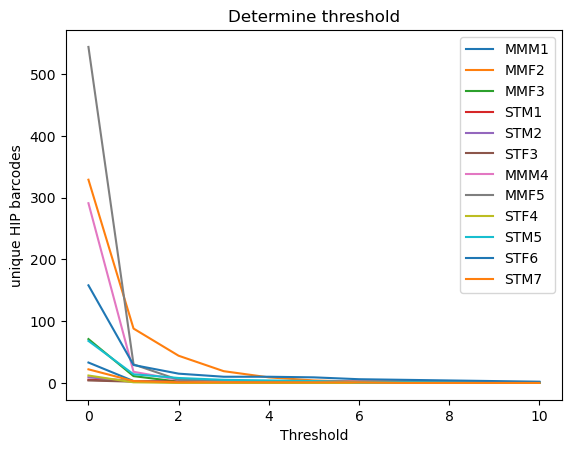

In [5]:
# determine threshold - based on below graph, threshold (conservative) can be set as 4

plot = pd.DataFrame(index=mice, columns=range(11))

for i in range(num_samples):
    for j in range(11):
        hip_u = (data_clean[i]["HIP"] > j).sum()
        plot.iloc[i,j] = hip_u

for i in range(num_samples):
    plt.plot(plot.iloc[i], label=mice[i])

plt.legend()
plt.xlabel('Threshold')
plt.ylabel("unique HIP barcodes")
plt.title("Determine threshold")
plt.show()

# seperate by individual areas

In [6]:
inj_sites = ["AOMCi", "POMCi", "ACAi"]
somc = "AOMCi|POMCi"
saca = "ACAi"

# create list for data_clean seperated by injection site (omc or aca)
dsC_omc = []
dsC_aca = []

for i in range(num_samples):
    inj = data_clean[i][inj_sites]
    omc_idx = inj.idxmax(axis=1).str.contains(somc)
    dsC_omc.append(data_clean[i][omc_idx])
    dsC_aca.append(data_clean[i][~omc_idx])

cols = ['OB', 'OMCi', 'ACAi', 'OMCc', 'ACAc', 'AUD', 'STR',
       'TH', 'HY', 'AMY', 'HIP', 'SNr', 'SCm', 'PG', 'PAG', 'RN']
    
# combine AOMC and POMC
for i in range(num_samples):
    dsC_omc[i]["OMCi"] = dsC_omc[i]["AOMCi"] + dsC_omc[i]["POMCi"]
    dsC_aca[i]["OMCi"] = dsC_aca[i]["AOMCi"] + dsC_aca[i]["POMCi"]
    dsC_omc[i]["OMCc"] = dsC_omc[i]["AOMCc"] + dsC_omc[i]["POMCc"]
    dsC_aca[i]["OMCc"] = dsC_aca[i]["AOMCc"] + dsC_aca[i]["POMCc"]
    dsC_omc[i] = dsC_omc[i][cols]
    dsC_aca[i] = dsC_aca[i][cols]


/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_13290/1762950448.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dsC_omc[i]["OMCi"] = dsC_omc[i]["AOMCi"] + dsC_omc[i]["POMCi"]
/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_13290/1762950448.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dsC_aca[i]["OMCi"] = dsC_aca[i]["AOMCi"] + dsC_aca[i]["POMCi"]
/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_13290/1762950448.py:22: SettingWithCopyWarning: 
A value is trying to

In [11]:
# set threshold=4
# under this threshold = false positive, so set to 0
omc_counts = []
aca_counts = []
for i in range(num_samples):
    omc_df = dsC_omc[i].copy()
    omc_df[omc_df <= 4] = 0
    aca_df = dsC_aca[i].copy()
    aca_df[aca_df <= 4] = 0
    omc_counts.append(omc_df)
    aca_counts.append(aca_df)
    

In [13]:
# SAVE DATA - COUNT DATA
with open(out_path + 'M194_M220_OMC_count4.pkl', 'wb') as f:
    pickle.dump(omc_counts, f, protocol=-1)
    
with open(out_path + 'M194_M220_ACA_count4.pkl', 'wb') as f:
    pickle.dump(aca_counts, f, protocol=-1)

In [14]:

# binarize - SET THRESHOLD AS 4 AS DETERMINED ABOVE
omc_bin = []
aca_bin = []
for i in range(num_samples):
    omc_bin.append(pd.DataFrame(binarize(dsC_omc[i], threshold=4), columns=dsC_omc[i].columns))
    aca_bin.append(pd.DataFrame(binarize(dsC_aca[i], threshold=4), columns=dsC_aca[i].columns))
    


In [15]:
# SAVE DATA - BINARY
with open(out_path + 'M194_M220_OMC_bin4.pkl', 'wb') as f:
    pickle.dump(omc_bin, f, protocol=-1)
    
with open(out_path + 'M194_M220_ACA_bin4.pkl', 'wb') as f:
    pickle.dump(aca_bin, f, protocol=-1)